# WEEK 4:

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import requests
import geocoder # import geocoder
from geopy.geocoders import Nominatim 
import folium # map rendering library

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CLIENT_ID = 'NNO2TDZ2XO2YHCMISLHPTUFBAK0YDZBX3RTF04YY4Q5FVR1W' # your Foursquare ID
CLIENT_SECRET = 'UTNENPNX0IFTQP1VPKXI035AFXQEC5XJCN0XJ5YRMYB05HAH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [53]:
def getNearbyVenues(names, latitudes, longitudes, radius=2500, LIMIT=20000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [803]:
def clusterCorrelations(corr_matrix, cluster_number, sortby_corr_strength=False):
    kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(corr_matrix)
    corr_matrix['cluster_labels']=kmeans.labels_
        
    cluster_labels_df=corr_matrix['cluster_labels'].value_counts().to_frame()
    cluster_labels_df=cluster_labels_df.rename(columns={'cluster_labels': 'cluster_size'})
    
    for i in range(0, cluster_number):
        cluster_types=corr_matrix[corr_matrix.cluster_labels==i].index.values.tolist()
        cluster_labels_df.loc[i, 'corr_strength']= np.abs(corr_matrix.loc[cluster_types, cluster_types].mean().mean())
        
    cluster_labels_df['new label']=1
    if sortby_corr_strength:
        cluster_labels_df['new label']=cluster_labels_df.sort_values('corr_strength', ascending=False)['new label'].cumsum()
        cluster_size_list=cluster_labels_df.sort_values('corr_strength', ascending=False).cluster_size.values.tolist()
        display(cluster_labels_df[['new label', 'corr_strength', 'cluster_size']].sort_values('corr_strength', ascending=False))

    else:
        cluster_labels_df['new label']=cluster_labels_df['new label'].cumsum()
        luster_size_list=cluster_labels_df.cluster_size.values.tolist()
        display(cluster_labels_df[['new label', 'corr_strength', 'cluster_size']])
    
    corr_matrix['cluster_labels']=corr_matrix['cluster_labels'].apply(lambda x: cluster_labels_df.loc[x]['new label'])    
    clustered_venues=corr_matrix.sort_values('cluster_labels').index.values.tolist()
    corr_matrix=corr_matrix.loc[clustered_venues, clustered_venues+ ['cluster_labels']]    
        
    fig, (ax1, ax2)=plt.subplots(1,2)
    ax1.imshow(corr_matrix.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')
    ax2.imshow(corr_matrix.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')    
    
    cluster_line=0
    for cluster_size in cluster_size_list:
        cluster_line+=cluster_size
        ax2.axhline(cluster_line-0.5)
        ax2.axvline(cluster_line-0.5)
    
    plt.show()

### Scrape the Table on the given Wikipedia Page with Beautiful Soup and Display the head of the DataFrame

In [55]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)

In [56]:
soup = BeautifulSoup(page.text, "html.parser")
table = soup.find('table')
table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
df=pd.DataFrame(l, columns=["Postcode", "Borough", "Neighbourhood"])
df=df[df['Borough']!='Not assigned'].dropna()
df['Neighbourhood']=df['Neighbourhood'].str.replace('\n','')

In [57]:
# Group together rows with the same postalcode as required
df=df.groupby(['Postcode', 'Borough']).agg(lambda col: ', '.join(col)).reset_index()

# Fill 'Not- assigned'-values in Neighbourhood-Column with Borough-Name and display the changed rows
na_idx=df[df.Neighbourhood.str.contains('Not assigned')].index
df.loc[na_idx,'Neighbourhood']=df.loc[na_idx,'Borough']

### Filter on Toronto Boroughs only
toronto_df=df[df.Borough.str.contains('Toronto')]

# Load coordinates and merge
coordinates=pd.read_csv('Geospatial_Coordinates.csv')
toronto_df=pd.merge(toronto_df, coordinates, left_on='Postcode', right_on='Postal Code').drop('Postal Code', axis=1)

### Get Venues Nearby

In [58]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

### Count Venues per Neighborhood

In [352]:
#venues_per_neighborhood=toronto_venues.groupby('Neighborhood').count().iloc[:,2].to_frame()

In [353]:
#venues_per_neighborhood=venues_per_neighborhood.sort_values('Venue', ascending=False)
#venues_per_neighborhood[venues_per_neighborhood.Venue>70].shape

In [354]:
#top_neighborhoods=venues_per_neighborhood[venues_per_neighborhood.Venue>70].index.values.tolist()

In [355]:
#print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

In [819]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#toronto_onehot.head()

In [820]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

# Cluster Venues bases on Corrleation of their occurences

## Filter on Top Venues only in order to avoid getting high correlations due to single/low-number data points

In [821]:
pd.options.display.max_rows=20
pd.options.display.max_columns=1000

In [822]:
venue_count=toronto_onehot.drop('Neighborhood', axis=1).T.sum(axis=1).to_frame()
venue_count=venue_count.rename(columns={0:'count'})
venue_count=venue_count.sort_values('count', ascending=False)
top_venue_types=venue_count.iloc[0:int(venue_count.shape[0]/4)].index.values.tolist()

In [823]:
venue_categories=pd.DataFrame({'venue_type':top_venue_types})

In [824]:
#venue_categories=toronto_onehot.drop('Neighborhood', axis=1).columns.to_frame().reset_index(drop=True)
#venue_categories=venue_categories.rename(columns={0: 'venue_type'})

In [825]:
toronto_onehot=toronto_onehot[['Neighborhood']+top_venue_types]

In [826]:
restaurant_types=venue_categories[venue_categories.venue_type.str.contains('Restaurant')].venue_type.values.tolist()
venue_corr=toronto_onehot.groupby(['Neighborhood']).sum().corr()
restaurant_corr=toronto_onehot[['Neighborhood']+restaurant_types].groupby(['Neighborhood']).sum().corr().sort_values('American Restaurant', ascending=False)

restaurant_types=restaurant_corr.index.values.tolist()
restaurant_corr=restaurant_corr[restaurant_types]

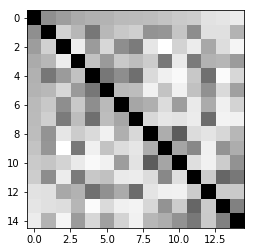

In [827]:
plt.imshow(restaurant_corr,cmap='Greys',interpolation='nearest')
#plot_corr(restaurant_corr[restaurant_types])

In [828]:
scores=list()

# set number of clusters
#kclusters = 2

for kclusters in range(1,restaurant_corr.shape[0]):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_corr)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 
    scores.append(kmeans.score(restaurant_corr))

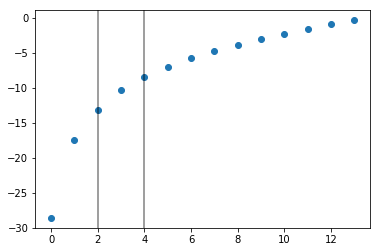

In [829]:
plt.axvline(2, color='k', alpha=0.5)
plt.axvline(4, color='k', alpha=0.5)
plt.scatter(np.linspace(0,len(scores)-1,len(scores)), scores)

,new label,corr_strength,cluster_size
1,1,0.276441,7
0,2,0.222644,8


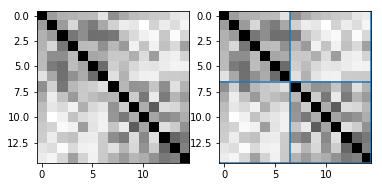

,new label,corr_strength,cluster_size
2,1,0.493697,3
1,2,0.419407,5
0,3,0.276441,7


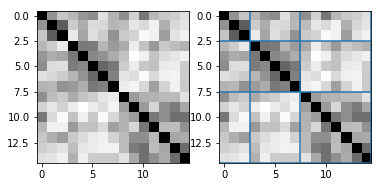

,new label,corr_strength,cluster_size
2,1,0.493697,3
0,2,0.491845,4
3,3,0.432671,3
1,4,0.419407,5


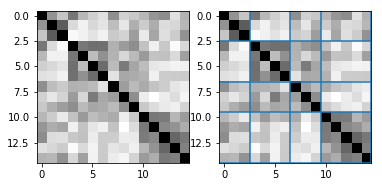

,new label,corr_strength,cluster_size
0,1,1.000000,1
4,2,0.769664,2
3,3,0.491845,4
2,4,0.432671,3
1,5,0.419407,5


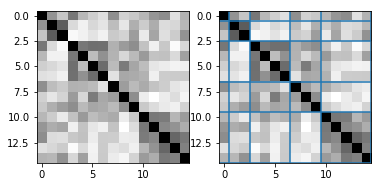

In [830]:
for i in range(2,6):
        clusterCorrelations(restaurant_corr, i, True)

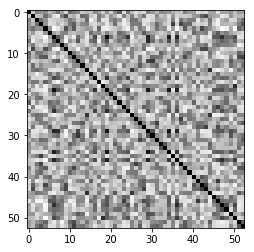

In [831]:
plt.imshow(venue_corr,cmap='Greys',interpolation='nearest')

In [832]:
scores=list()

# set number of clusters
#kclusters = 2

for kclusters in range(1,venue_corr.shape[0]):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_corr)

    # check cluster labelcs generated for each row in the dataframe
    #kmeans.labels_[0:10] 
    scores.append(kmeans.score(venue_corr))

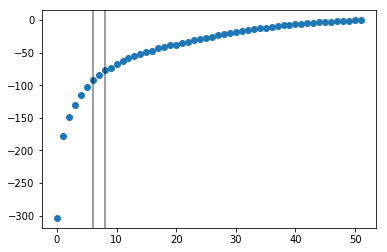

In [833]:
plt.axvline(6, color='k', alpha=0.5)
plt.axvline(8, color='k', alpha=0.5)
plt.scatter(np.linspace(0,len(scores)-1,len(scores)), scores)

,new label,corr_strength,cluster_size
2,1,0.470956,14
3,2,0.371863,9
1,3,0.254386,12
0,4,0.252564,18


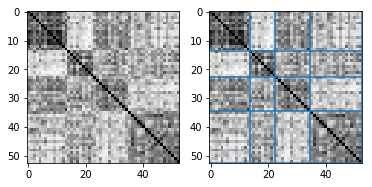

,new label,corr_strength,cluster_size
2,1,0.470956,14
1,2,0.395824,10
3,3,0.387466,8
4,4,0.371863,9
0,5,0.254386,12


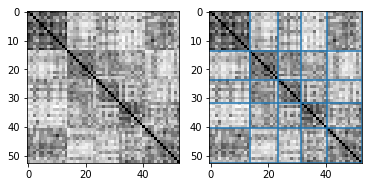

,new label,corr_strength,cluster_size
2,1,0.607382,9
5,2,0.542153,5
1,3,0.395824,10
4,4,0.387466,8
0,5,0.371863,9
3,6,0.254386,12


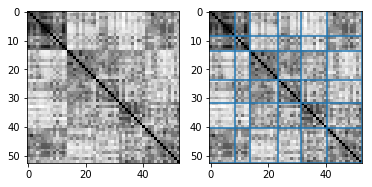

,new label,corr_strength,cluster_size
1,1,0.607382,9
5,2,0.542153,5
0,3,0.526598,6
3,4,0.492884,7
6,5,0.481958,4
4,6,0.395824,10
2,7,0.254386,12


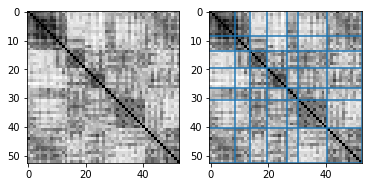

,new label,corr_strength,cluster_size
1,1,0.737872,7
7,2,0.691312,3
5,3,0.526598,6
6,4,0.505084,4
3,5,0.492884,7
0,6,0.481958,4
4,7,0.395824,10
2,8,0.254386,12


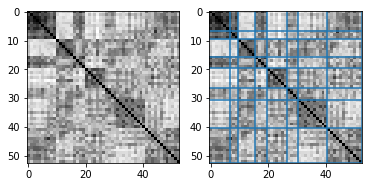

In [834]:
for i in range(4,9):
    clusterCorrelations(venue_corr, i, True)

# Can we Do better if we sum over correlated restaurants (2 clusters)

,new label,corr_strength,cluster_size
1,1,0.419407,5
0,2,0.123838,10


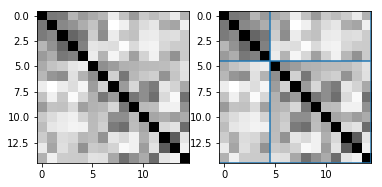

In [836]:
clusterCorrelations(restaurant_corr, 2, True)

In [837]:
restaurant_corr.columns

Index(['American Restaurant', 'French Restaurant', 'Seafood Restaurant',
       'Middle Eastern Restaurant', 'Mediterranean Restaurant',
       'Vegetarian / Vegan Restaurant', 'Restaurant', 'Thai Restaurant',
       'Vietnamese Restaurant', 'Indian Restaurant', 'Asian Restaurant',
       'Italian Restaurant', 'Japanese Restaurant', 'Sushi Restaurant',
       'Mexican Restaurant', 'cluster_labels'],
      dtype='object')

In [838]:
restaurants_1=restaurant_corr[restaurant_corr['cluster_labels']==1].index.values.tolist()
restaurants_2=restaurant_corr[restaurant_corr['cluster_labels']==2].index.values.tolist()

In [839]:
restaurant_corr.loc[restaurants_1, restaurants_1]

,Middle Eastern Restaurant,Indian Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant
Middle Eastern Restaurant,1.000000,0.376242,0.361741,0.045866,0.181094
Indian Restaurant,0.376242,1.000000,0.285230,0.225291,0.086724
Italian Restaurant,0.361741,0.285230,1.000000,0.477971,0.375210
Sushi Restaurant,0.045866,0.225291,0.477971,1.000000,0.327214
Mexican Restaurant,0.181094,0.086724,0.375210,0.327214,1.000000


In [840]:
toronto_onehot['restaurants_1']=toronto_onehot[restaurants_1].sum(axis=1)

In [841]:
toronto_onehot_restaurants_summed=toronto_onehot.drop(restaurants_1, axis=1)

In [842]:
venue_categories=pd.DataFrame({'venue_type':top_venue_types+['restaurants_1']})

In [843]:
venue_categories=venue_categories[~venue_categories.venue_type.isin(restaurants_1)].dropna()

In [844]:
top_venues=venue_categories.venue_type.tolist()

In [845]:
toronto_onehot=toronto_onehot_restaurants_summed[['Neighborhood']+top_venues]

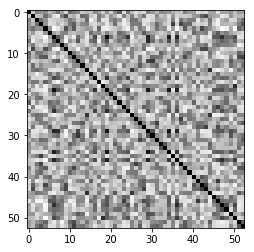

In [848]:
plt.imshow(venue_corr.drop('cluster_labels', axis=1),cmap='Greys',interpolation='nearest')
#plot_corr(restaurant_corr[restaurant_types])

In [849]:
scores=list()

# set number of clusters
#kclusters = 2

for kclusters in range(1,venue_corr.shape[0]):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_corr)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 
    scores.append(kmeans.score(venue_corr))

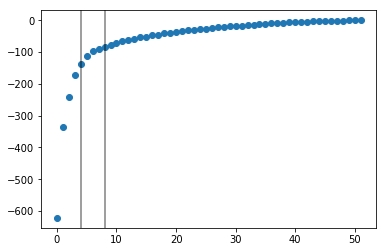

In [850]:
plt.axvline(4, color='k', alpha=0.5)
plt.axvline(8, color='k', alpha=0.5)
plt.scatter(np.linspace(0,len(scores)-1,len(scores)), scores)

,new label,corr_strength,cluster_size
0,1,0.590460,11
1,2,0.263373,14
2,3,0.254386,12
3,4,0.169435,16


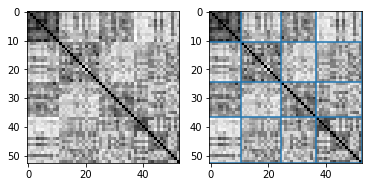

,new label,corr_strength,cluster_size
2,1,0.590460,11
3,2,0.500112,7
4,3,0.462909,7
1,4,0.263373,14
0,5,0.197855,14


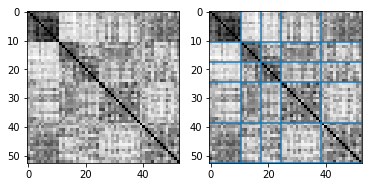

,new label,corr_strength,cluster_size
1,1,0.590460,11
3,2,0.500112,7
5,3,0.462909,7
4,4,0.441579,5
0,5,0.395824,10
2,6,0.235216,13


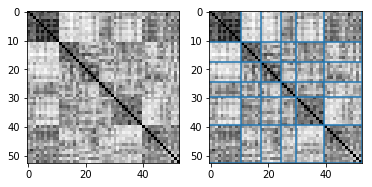

,new label,corr_strength,cluster_size
1,1,0.590460,11
6,2,0.500112,7
3,3,0.462909,7
4,4,0.441579,5
0,5,0.395824,10
2,6,0.376275,6
5,7,0.360580,7


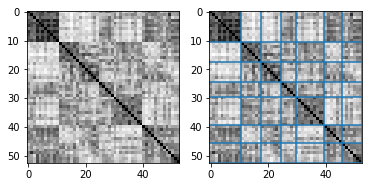

In [851]:
for i in range(4,8):
        clusterCorrelations(venue_corr, i, True)

In [871]:
cluster1=venue_corr[venue_corr.cluster_labels==1].index.values.tolist()

In [872]:
cluster1

['Hotel',
 'Japanese Restaurant',
 'Thai Restaurant',
 'Theater',
 'Farmers Market',
 'Steakhouse',
 'Plaza',
 'Concert Hall',
 'Mediterranean Restaurant',
 'Comic Shop',
 'Museum']

In [858]:
toronto_cluster1_venues=toronto_onehot_restaurants_summed[['Neighborhood']+cluster1]

In [859]:
toronto_cluster1_venues['venue_number']=toronto_cluster1_venues[cluster1].sum(axis=1)

/home/bardiya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [861]:
toronto_cluster1_venues.groupby('Neighborhood').sum()

,Hotel,Japanese Restaurant,Thai Restaurant,Theater,Farmers Market,Steakhouse,Plaza,Concert Hall,Mediterranean Restaurant,Comic Shop,Museum,venue_number
Neighborhood,,,,,,,,,,,,
"Adelaide, King, Richmond",5,3,2,3,2,2,2,2,1,1,1,24
Berczy Park,5,2,2,4,3,2,2,2,1,0,1,24
"Brockton, Exhibition Place, Parkdale Village",3,2,1,1,0,0,0,0,0,0,0,7
Business Reply Mail Processing Centre 969 Eastern,1,0,0,0,1,0,0,0,0,1,0,3
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",4,2,0,1,0,1,2,0,1,0,0,11
"Cabbagetown, St. James Town",3,3,3,3,1,1,1,1,1,2,0,19
Central Bay Street,3,3,1,3,1,2,1,3,1,1,1,20
"Chinatown, Grange Park, Kensington Market",1,1,1,1,0,1,0,1,1,0,0,7
Christie,0,1,0,0,1,0,0,0,0,0,1,3


In [878]:
venue_corr.loc[cluster1, cluster1].drop('Thai Restaurant')['Thai Restaurant'].values

array([0.59340776, 0.44758374, 0.70149058, 0.61308765, 0.52844748,
       0.54144064, 0.55602232, 0.43116016, 0.38278161, 0.26914897])

In [966]:
thai_pred=np.array(toronto_cluster1_venues.groupby('Neighborhood').sum().drop('Thai Restaurant', axis=1).drop('venue_number', axis=1))
weights=venue_corr.loc[cluster1, cluster1].drop('Thai Restaurant')['Thai Restaurant'].values.reshape(10,1)

In [967]:
results=toronto_cluster1_venues.groupby('Neighborhood').sum()

In [978]:
#results[cluster1].drop('Thai Restaurant', axis=1)=
pred=(thai_pred*weights.T).mean(axis=1)

In [979]:
real=np.array(results['Thai Restaurant'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc07428c400>]],
      dtype=object)

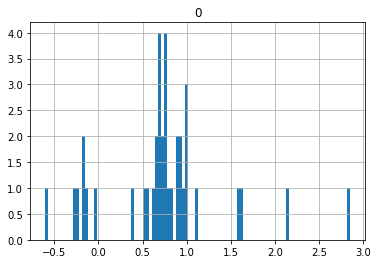

In [989]:
pd.DataFrame((real-pred)).hist(bins=100)

In [1007]:
res=np.matmul((thai_pred*weights.T),((thai_pred*weights.T)!=0.0).astype(int).T)

In [1019]:
aa=((thai_pred*weights.T)!=0.0).astype(int).sum(axis=1)
pred2=np.diagonal(res)/aa

/home/bardiya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc06f95a240>]],
      dtype=object)

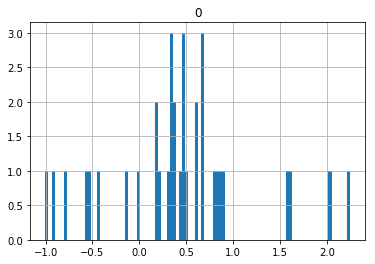

In [1025]:
pd.DataFrame((real-pred2)).hist(bins=100)